<a href="https://colab.research.google.com/github/KimYongHee11/first/blob/main/%EB%B9%84%EC%A0%95%ED%98%95%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D_%EA%B3%B5%EC%A4%80%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import**

In [ ]:
!pip install --upgrade pip
!pip install konlpy  
!pip install nltk
!pip install glove_python_binary

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import os
from tqdm import tqdm, tqdm_pandas

from konlpy.tag import Okt
okt = Okt()
from konlpy.tag import Mecab

import sklearn
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import log_loss, accuracy_score,f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings(action='ignore')

from gensim.models.word2vec import Word2Vec
from nltk.tokenize import word_tokenize, sent_tokenize

from glove import Corpus, Glove
from gensim.models import Word2Vec

from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 한글폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# 한글 폰트 적용
plt.rcParams['font.family'] = 'NanumGothic'

# **Data Load**

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/2021 비정형데이터 분석(UOS)/퀴즈4/'

In [ ]:
train=pd.read_csv(file_path+'train.csv')
test=pd.read_csv(file_path+'test.csv')
sample_submission=pd.read_csv(file_path+'sample_submission.csv')

In [ ]:
train.fillna('NoContent', inplace=True)
test.fillna('NoContent', inplace=True)

# **전처리**

In [ ]:
okt = Okt()
def trans_token(text):
  text = re.sub('가\.',' ',str(text))
  text = re.sub('나\.',' ',text)
  # text = re.sub('-\d+','num', text)
  text = re.sub('\<br\>',' ',text)
  text = re.sub('[\*\n]',' ',text)
  text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z\- ]"," ", text)
  text = text.lower()
  if len(text) == 0:
    return ['NoContent']
  return okt.pos(text)

In [ ]:
# 키워드는 대부분 품사가 명사임
tokens = okt.pos(train['과제명'].loc[0])
only_noun = [ x[0] for x in tokens if x[1] == 'Noun']
print(train['과제명'].loc[0])
print(only_noun)

In [ ]:
# 띄어쓰기와 전문용어가 많은 데이터 특성상 

tokens = okt.pos(train['과제명'].loc[21])
only_noun = [ x[0] for x in tokens if x[1] in ['Noun', 'Alpha']]
print(train['과제명'].loc[21])
print(only_noun)
print(okt.pos(train['과제명'].loc[21]))
# 띄어쓰기 문제로 한 단어가 Modifier(수식언,관형사)로 잘못 분리, 구조물 -> 구 + 조물

In [ ]:
tokens = okt.pos(train['과제명'].loc[1])
only_noun = [ x[0] for x in tokens if x[1] in ['Noun', 'Alpha']]
print(train['과제명'].loc[1])
print(only_noun)
print(okt.pos(train['과제명'].loc[1]))
# 잘못된 Determiner(관형사) 분리로 내성이라는 고유의 의미를 갖는 명사가 내, 성으로 쪼개짐 

In [ ]:
tokens = okt.pos(train['요약문_연구목표'].loc[13])
only_noun = [ x[0] for x in tokens if x[1] in ['Noun', 'Alpha']]
print(train['요약문_연구목표'].loc[13][140:180])
print(only_noun[30:40])
print(okt.pos(train['요약문_연구목표'].loc[13][140:175]))
# Modifier(수식언,관형사), Suffix(접미사) 잘못 분리/ 전자구조-> 전 + 자구 + 조

In [ ]:
kor_stop_words = ['후', '재', '통해', '통한','적','트','급','함','그','대한','은','상','인','무','피',
                  '용','활용','급','을','를','것','것임','임','기반','통한','별','때','외','못','기','년',
                  '차','간','등', '이','내','또','중','다른','역','일','제','통','시','총','상의','법','로',
                  '이들','물','개','년','건','주','사','점','계','각','더','뿐','안','두','유','과','와','덜',
                  '회','전','약','바','즉','신','데','좀','더','리','몇','최','번','움','줌','음','샤','셔',
                  '그것','형',
                  ]
custom_stop_words = ['주요','목표','개선','향상','과제','개발','기술','연구','선행','시스템','다음','매우','이용','로서','기존',
                     '극복','장점','단점','문제','문제점','각각','관련','부분','간의','이상','달성','주된내용','내용','국내',
                     '해외','최종','사용','효과','기관','제공','이하','목적','년차','필요','때문','로부터','최종적','만개','크게',
                     '모두','의미','여러','하나로','중심','한번','창','실','베','헤','핑','메','위해','차년','년도']

noun_char_to_front = ['러닝','품','체','층','능','브','스','물','팅','이드','버','리움','링','터','레이','베이','막','단','산',
                      '신','량','사체','액','망','켓','션','텍','틴','셋','론']

kor_stop_words = kor_stop_words + custom_stop_words
eng_stop_words = list(set(stopwords.words('english') + ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']))
stop_words = kor_stop_words + eng_stop_words

Modifier_to_front = ['칠','귀','속','별','너','두','흔','울','댓','성']
Modifier_no_change = ['동','총','순','양대', '일대','전전','다른','닷']
Modifier_to_Noun = ['암','즉석','기만','수조','온간','수삼']


def fixed_okt_tokenizer(text):

  tuple_tokens = text
  list_tokens = []
  for i in tuple_tokens:
    list_tokens.append(list(i))
  for i in range(len(list_tokens)):

    #보편적으로 작업해줘야하는 것
    if i < len(list_tokens) - 1:

      if (list_tokens[i+1][1] == 'Modifier') and (list_tokens[i+1][0] in Modifier_to_front):
        list_tokens[i][0] = list_tokens[i][0] + list_tokens[i+1][0]
        list_tokens[i][1] = 'Noun'
        list_tokens[i+1][1] = '제외'
        continue

      elif (list_tokens[i][1] == 'Modifier') and (list_tokens[i][0] not in (Modifier_to_front + Modifier_no_change + Modifier_to_Noun)):
        if (list_tokens[i][0] == '양') and (list_tokens[i-1][0] == '요' and list_tokens[i-1][1] == 'Josa'):
          list_tokens[i-1][0] = list_tokens[i-1][0] + list_tokens[i][0]
          list_tokens[i-1][1] = 'Noun'
          continue

        list_tokens[i+1][0] = list_tokens[i][0] + list_tokens[i+1][0]
        list_tokens[i+1][1] = 'Noun'
  
        continue

      elif (list_tokens[i][1] == 'Suffix') and (list_tokens[i][0] == '분') and list_tokens[i+1][0][0] in ['리','류','석']:
        list_tokens[i+1][0] = list_tokens[i][0] + list_tokens[i+1][0]
        list_tokens[i+1][1] = 'Noun'
        continue

      elif (list_tokens[i][1] == 'Determiner') and (list_tokens[i+1][1] == 'Noun'):
        list_tokens[i+1][0] = list_tokens[i][0] + list_tokens[i+1][0]
        list_tokens[i][1] = '제외'
        continue

      elif (list_tokens[i][0] in ['위','관'] and (list_tokens[i][1] == 'Noun')) and ((list_tokens[i+1][1] == 'Verb') or (list_tokens[i+1][1] == 'Josa')): # 위하여, 위한, 위해서는, 관하여, 관한, 관해서는 등 제거
        list_tokens[i][1] = '제외'
        continue

      elif ((list_tokens[i][0] == '및' or (list_tokens[i][0] == '의')) and (list_tokens[i][1] == 'Noun')): # 및 제거
        list_tokens[i][1] = '제외'
        continue

      elif (list_tokens[i][0] == ('초') and (list_tokens[i][1] == 'Noun')) and (list_tokens[i+1][1] == 'Noun'):
        list_tokens[i+1][0] = list_tokens[i][0] + list_tokens[i+1][0]
        list_tokens[i][1] = '제외'
        continue

      elif (list_tokens[i][0] in ['퇴','초','비','산'] and (list_tokens[i][1] == 'Noun')):
        if (list_tokens[i][0] == '산') and (list_tokens[i+1][0] != '업체'):
          continue 
        list_tokens[i][1] = '제외'
        list_tokens[i+1][0] = list_tokens[i][0] + list_tokens[i+1][0]
        # list_tokens[i+1][1] = 'Noun'
        continue

      elif (list_tokens[i][0] == '검' and (list_tokens[i][1] == 'Noun')):
        list_tokens[i][1] = '제외'
        list_tokens[i+1][1] = 'Noun'
        if list_tokens[i+1][0][0] == '출':
          list_tokens[i+1][0] = '검출'
          continue
        list_tokens[i+1][0] = list_tokens[i][0] + list_tokens[i+1][0]
        continue
      
      elif (list_tokens[i][0] == '변' and list_tokens[i][1] == 'Noun') and (list_tokens[i+1][0][0] == '이'):
        list_tokens[i][1] = '제외'
        list_tokens[i+1][0] = '변이'
        list_tokens[i+1][1] = 'Noun'
        continue

      elif (list_tokens[i][0] == '실' and list_tokens[i][1] == 'Noun') and (list_tokens[i+1][0][0] == '내'):
        list_tokens[i][1] = '제외'
        list_tokens[i+1][0] = list_tokens[i][0] + list_tokens[i+1][0]
        continue

      elif (list_tokens[i][0] == '할' and (list_tokens[i][1] == 'Verb')) and (list_tokens[i+1][0] == '수' and (list_tokens[i+1][1] == 'Noun')):
        list_tokens[i+1][1] = '제외'



    if (list_tokens[i][1] == 'Modifier') and (list_tokens[i][0] in Modifier_no_change):
      continue

    elif (list_tokens[i][1] == 'Modifier') and (list_tokens[i][0] in Modifier_to_Noun):
      list_tokens[i][1] = 'Noun'

    elif (list_tokens[i][1] == 'Suffix') or ((list_tokens[i][0] == '학') or (list_tokens[i][0] == '율') or (list_tokens[i][0] == '률')):
      if (list_tokens[i][0] in ['들']):
        continue
      list_tokens[i][0] = list_tokens[i-1][0] + list_tokens[i][0]
      list_tokens[i][1] = 'Noun'
      list_tokens[i-1][1] = 'Josa'
      
      
    #뒷 글자를 앞에 붙일 때 
    elif (list_tokens[i][0] == ('기후학') and (list_tokens[i][1] == 'Noun')) and (list_tokens[i-1][0] == ('법') and (list_tokens[i-1][1] == 'Noun')):
      list_tokens[i-1][0] = list_tokens[i-1][0] + list_tokens[i][0]
      list_tokens[i][1] = 'JOSA'

    elif (list_tokens[i][0] in noun_char_to_front) and (list_tokens[i][1] == 'Noun'):
      if (list_tokens[i][0] in ['물']) and (list_tokens[i-1][1] != 'Noun'):
        continue
      elif (list_tokens[i][0] == '버') and (list_tokens[i-1][0][-1] not in ['이','터']):
        continue
      elif (list_tokens[i][0] == '스') and (list_tokens[i-1][0][-1] not in ['레']):
        continue
      elif (list_tokens[i][0] == '신') and (list_tokens[i-1][0][-1] not in ['수']):
        continue
      elif (list_tokens[i][0] == '산') and (list_tokens[i-1][0] not in ['국내']):
        continue
      elif (list_tokens[i][0] == '사체') and (list_tokens[i-1][0] not in ['피전','피']):
        continue
      elif (list_tokens[i][0] == '러닝') and (list_tokens[i-1][0] not in ['딥']):
        continue

      elif (list_tokens[i][0] in ['레이','베이']) and (i != 0):
        list_tokens[i][0] = list_tokens[i-1][0] + list_tokens[i][0]
        list_tokens[i-1][1] = '제외'
        continue


      list_tokens[i][1] = '제외'
      list_tokens[i-1][0] = list_tokens[i-1][0] + list_tokens[i][0]
      if list_tokens[i][0] in ['이드','리움','링']:
        list_tokens[i-1][1] = 'Noun'


    elif (list_tokens[i][0] == ('열') and (list_tokens[i][1] == 'Noun')) and (list_tokens[i-1][1] == 'Noun'):
      list_tokens[i-1][0] = list_tokens[i-1][0] + list_tokens[i][0]
      list_tokens[i][1] = '제외'
    elif list_tokens[i][0][:2] == ('백신'):
      list_tokens[i][0] = '백신'
      list_tokens[i][1] = 'Noun' 
    elif (i != 0) and (i != len(list_tokens) - 1) and (list_tokens[i][0] == '-'):
      if (list_tokens[i-1][1] == 'Alpha') and (list_tokens[i+1][1] in ['Alpha','Number']):
        list_tokens[i-1][1] = '제외'
        list_tokens[i][1] = '제외'
        list_tokens[i+1][1] = 'Noun'
        list_tokens[i+1][0] = list_tokens[i-1][0] + list_tokens[i][0] + list_tokens[i+1][0]
    elif ((list_tokens[i][0] == '형') and (list_tokens[i][1] == 'Noun')) and (okt.pos(list_tokens[i-1][0])[-1][1] in ['Number','Alpha']):
      list_tokens[i][1] = '제외'
      list_tokens[i-1][0] = list_tokens[i-1][0] + list_tokens[i][0]
        

  tokens = []
  for word, tag in list_tokens : 
      if (tag in ['Noun', 'Alpha']) and (word not in stop_words):  #명사, 알파뱃만 사용
          tokens.append(word)
  return tokens

In [ ]:
index = 21
tokens = okt.pos(train['과제명'].loc[index])
only_noun = [ x[0] for x in tokens if x[1] in ['Noun', 'Alpha']]
print('    원문 :',train['과제명'].loc[index])
print('okt 기본 :',okt.morphs(train['과제명'].loc[index]))
print('okt 명사 :',only_noun)
# print('okt 튜닝 :',new_okt_tokenizer(trans_token(train['과제명'].loc[index])))

In [ ]:
index = 1
tokens = okt.pos(train['과제명'].loc[index])
only_noun = [ x[0] for x in tokens if x[1] in ['Noun', 'Alpha']]
print('    원문 :',train['과제명'].loc[index])
print('okt 기본 :',okt.morphs(train['과제명'].loc[index]))
print('okt 명사 :',only_noun)
# print('okt 튜닝 :',new_okt_tokenizer(trans_token(train['과제명'].loc[index])))

In [ ]:
index = 13
tokens = okt.pos(train['요약문_연구목표'].loc[index])
only_noun = [ x[0] for x in tokens if x[1] in ['Noun', 'Alpha']]
print('    원문 :',train['요약문_연구목표'].loc[index][141:200])
print('okt 기본 :',okt.morphs(train['요약문_연구목표'].loc[index])[58:76])
print('okt 명사 :',only_noun[30:40])
# print('okt 튜닝 :',new_okt_tokenizer(trans_token(train['요약문_연구목표'].loc[index]))[25:40])

In [ ]:
num = 1706
tokens = okt.pos(train['요약문_연구목표'].loc[num])
only_noun = [ x[0] for x in tokens if x[1] in ['Noun', 'Alpha']]
print('    원문 :',train['요약문_연구목표'].loc[num][30:106])
print('okt 기본 :',okt.morphs(train['요약문_연구목표'].loc[num])[13:43])
print('okt 명사 :',only_noun[11:29])
# print('okt 튜닝 :',new_okt_tokenizer(trans_token(train['요약문_연구목표'].loc[num]))[8:19])

In [ ]:
index = 6

tokens = okt.pos(train['과제명'].loc[index])
only_noun = [ x[0] for x in tokens if x[1] in ['Noun', 'Alpha']]
print('    원문 :',train['과제명'].loc[index])
print('okt 기본 :',okt.morphs(train['과제명'].loc[index]))
print('okt 명사 :',only_noun)
# print('okt 튜닝 :',new_okt_tokenizer(trans_token(train['과제명'].loc[index])))

# 앞, 뒤 어느쪽에 붙여야할지 애매한 단어, 따로 처리를 해준 단어만 적용이 되기 때문에 적용이 균일하지는 않음
# 시스를 앞에 붙이는 처리를 할 수도 있지만, 뒤에 붙이는 경우가 나을 수도 있고, 이런식으로 데이터 확인과 처리작업을 해줘야하는 케이스가 매우 많음 -> 토큰화 성능에 편차 발생 
# '필기 도구 외 기타' 같은 의존명사 외 제거하기 위해 외를 stop word에 추가하여 토큰 삭제가 발생

In [ ]:
def united_contents(text):
  text = re.sub('\(R&D\)','',text)
  text = re.sub('\(\w+\)','',text)
  text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z ]','',text)
  return [text]

train['united_내역사업명'] = train['내역사업명'].apply(united_contents)
test['united_내역사업명'] = test['내역사업명'].apply(united_contents)

In [ ]:
tqdm.pandas()

train['token_내역사업명'] = train['united_내역사업명'].progress_apply(trans_token)
train['token_과제명'] = train['과제명'].progress_apply(trans_token)
train['token_요약문_한글키워드'] = train['요약문_한글키워드'].progress_apply(trans_token)
train['token_요약문_연구목표'] = train['요약문_연구목표'].progress_apply(trans_token)

test['token_내역사업명'] = test['united_내역사업명'].progress_apply(trans_token)
test['token_과제명'] = test['과제명'].progress_apply(trans_token)
test['token_요약문_한글키워드'] = test['요약문_한글키워드'].progress_apply(trans_token)
test['token_요약문_연구목표'] = test['요약문_연구목표'].progress_apply(trans_token)

100%|██████████| 43576/43576 [57:15<00:00, 12.68it/s]


In [ ]:
train

In [ ]:
tqdm.pandas()

train['fixed_okt_내역사업명'] = train['token_내역사업명'].progress_apply(fixed_okt_tokenizer)
train['fixed_okt_과제명'] = train['token_과제명'].progress_apply(fixed_okt_tokenizer)
train['fixed_okt_요약문_한글키워드'] = train['token_요약문_한글키워드'].progress_apply(fixed_okt_tokenizer)
train['fixed_okt_요약문_연구목표'] = train['token_요약문_연구목표'].progress_apply(fixed_okt_tokenizer)

test['fixed_okt_내역사업명'] = test['token_내역사업명'].progress_apply(fixed_okt_tokenizer)
test['fixed_okt_과제명'] = test['token_과제명'].progress_apply(fixed_okt_tokenizer)
test['fixed_okt_요약문_한글키워드'] = test['token_요약문_한글키워드'].progress_apply(fixed_okt_tokenizer)
test['fixed_okt_요약문_연구목표'] = test['token_요약문_연구목표'].progress_apply(fixed_okt_tokenizer)

100%|██████████| 43576/43576 [00:41<00:00, 1048.81it/s]


In [ ]:
train1 = train[['index','fixed_okt_내역사업명','fixed_okt_과제명','fixed_okt_요약문_한글키워드','fixed_okt_요약문_연구목표','label','token_요약문_연구목표']]
test1 = test[['index','fixed_okt_내역사업명','fixed_okt_과제명','fixed_okt_요약문_한글키워드','fixed_okt_요약문_연구목표','token_요약문_연구목표']]

train1.to_csv(file_path + 'fixed_okt_train.csv',index=False)
test1.to_csv(file_path + 'fixed_test.csv',index=False)

---

# **전처리 1차 완료**

In [ ]:
train=pd.read_csv(file_path+'fixed_okt_train.csv')
test=pd.read_csv(file_path+'fixed_test.csv')

In [ ]:
# csv에는 리스트로 저장했던 것들이 문자열로 바뀌어있었으므로 문자열을 다시 리스트 형태로 변환
def trans_to_list(text):
  text = re.sub("[\[\]\' ]", "", str(text))
  text =  text.split(',')
  if text == ['']:
    text = ['']
  return text

train['fixed_okt_과제명'] = train['fixed_okt_과제명'].apply(trans_to_list)
train['fixed_okt_내역사업명'] = train['fixed_okt_내역사업명'].apply(trans_to_list)
train['fixed_okt_요약문_한글키워드'] = train['fixed_okt_요약문_한글키워드'].apply(trans_to_list)
train['fixed_okt_요약문_연구목표'] = train['fixed_okt_요약문_연구목표'].apply(trans_to_list)

test['fixed_okt_과제명'] = test['fixed_okt_과제명'].apply(trans_to_list)
test['fixed_okt_내역사업명'] = test['fixed_okt_내역사업명'].apply(trans_to_list)
test['fixed_okt_요약문_한글키워드'] = test['fixed_okt_요약문_한글키워드'].apply(trans_to_list)
test['fixed_okt_요약문_연구목표'] = test['fixed_okt_요약문_연구목표'].apply(trans_to_list)

In [ ]:
# 더 제외하고 싶은 단어 추가 

del_word = [
            '안팎','개념','역할','중심적','또한','특이적','개월','취급','변화',
            '고려','가량','일반적','지원','다기','관','종합적','도출','방안','검토',
            '산업','강화','기업','바탕','현장','조건','방법','성숙','해당과정','위해',
            '검토','확립','차년','진행','과정','구축','연구개발','결과물',
            '검증','방안','인재','분석','발굴','규명','적용','실제','거나','연구원',
            '운영','확보','대하','수','능력','평가','성과','발표','도록','마련','고',
            '따라서','대해','제시','통합적','종합적','말함','살피','최근','대두','일반',
            '발전','연구개발','경우','주어','기초','년간','담당','낼','대처','성의','핵심',
            '주목표','상위','하위','기대','시기','증대','증가','감소','고자','이바지',
            '이전','현재', '이번',
]

def add_filter(text):
  return [x for x in text if x not in del_word]

train['filter_okt_요약문_연구목표'] = train['fixed_okt_요약문_연구목표'].apply(add_filter)
test['filter_okt_요약문_연구목표'] = test['fixed_okt_요약문_연구목표'].apply(add_filter)

In [ ]:
train['vocab'] = train['fixed_okt_내역사업명'] + train['fixed_okt_과제명']  + train['fixed_okt_요약문_한글키워드'] + train['filter_okt_요약문_연구목표']

In [ ]:
pd.set_option('display.max_columns',None)
train.head()

,index,fixed_okt_내역사업명,fixed_okt_과제명,fixed_okt_요약문_한글키워드,fixed_okt_요약문_연구목표,label,token_요약문_연구목표,filter_okt_요약문_연구목표,vocab
0,0,"[농산물, 안전성]","[유전, 정보, 해충, 분류군, 동정]","[뉴클레오티드, 염기서열, 분자, 종, 동정, 침샘, 전사체]","[해충, 분류군, 동정, 유입, 확산, 추적]",24,"[('새로운', 'Adjective'), ('해충', 'Noun'), ('분류군',...","[해충, 분류군, 동정, 유입, 확산, 추적]","[농산물, 안전성, 유전, 정보, 해충, 분류군, 동정, 뉴클레오티드, 염기서열, ..."
1,1,"[지역, 대학, 우수, 과학자, 지원, 사업, 년년]","[대장암, trail, 내성, 표적, 인자, 발굴, trail, 반응, 예측, 유전...","[대장암, 항암제, 내성, 세포, 사멸, 유전자, 발굴]","[trail, 감수성, 표적, 유전자, 발굴, 내성, 제어, 기전, 발굴, 유전자,...",0,"[('최종', 'Noun'), ('목표', 'Noun'), ('trail', 'Al...","[trail, 감수성, 표적, 유전자, 내성, 제어, 기전, 유전자, trail, ...","[지역, 대학, 우수, 과학자, 지원, 사업, 년년, 대장암, trail, 내성, ..."
2,2,"[혁신, 기업]","[비목, 셀룰로오스, 식물, 자원, 기능성, 부직포, 고부가가치, 뷰티, 케어, f...","[기능성, 룰, 오스, 파이버, 천연섬유, 기능성, 부직포, 뷰티, amp, 케어,...","[식물계, 자원, 정련, 최적, 신서, 란, 파이버, 기초, 소비자, 바이어, 피드...",0,"[('식물계', 'Noun'), ('자원', 'Noun'), ('정련', 'Noun...","[식물계, 자원, 정련, 최적, 신서, 란, 파이버, 소비자, 바이어, 피드백, 식...","[혁신, 기업, 비목, 셀룰로오스, 식물, 자원, 기능성, 부직포, 고부가가치, 뷰..."
3,3,"[창업, 사업화, 연계]","[소화기, 암, 진단, 분자영상, 형광, 프로브]","[분자, 진단, 형광, 조영제, 프로브, 항체, 대장암]","[암, 특이적, 바이오, 발굴, 바이오, 프로브, 소화기, 암, 진단, 분자영상, ...",0,"[('암', 'Modifier'), ('특이', 'Noun'), ('적', 'Suf...","[암, 바이오, 바이오, 프로브, 소화기, 암, 진단, 분자영상, 형광, 프로브, ...","[창업, 사업화, 연계, 소화기, 암, 진단, 분자영상, 형광, 프로브, 분자, 진..."
4,4,"[기본, 연구지원]","[위암, 환자, 항암제, 반응, 예측, brca, 발현, 검사]","[brca, 제자리, 부, 합법, 조직, 미세, 배열, 마이크로, rna, 위암, ...","[수술, 위암, 환자, 생존, 기간, 개월, 안팎, 항, 암, 화학요법, 생존율, ...",0,"[('수술', 'Noun'), ('이', 'Josa'), ('불가능한', 'Adje...","[수술, 위암, 환자, 생존, 기간, 항, 암, 화학요법, 생존율, 약물, 치료, ...","[기본, 연구지원, 위암, 환자, 항암제, 반응, 예측, brca, 발현, 검사, ..."


# **단어사전**

In [ ]:
nouns = []

for doc in tqdm(train.vocab):
    for sent in doc:
        nouns.append(sent)

100%|██████████| 174304/174304 [00:01<00:00, 93208.48it/s]


In [ ]:
nouns[:10]

['농산물', '안전성', '유전', '정보', '해충', '분류군', '동정', '뉴클레오티드', '염기서열', '분자']

In [ ]:
count_dict = {}

for noun in nouns:
    try: 
        count_dict[noun] += 1
    except:
        count_dict[noun] = 1

In [ ]:
pd.DataFrame(count_dict.items(), columns=['Words','Counts']).head(10)

,Words,Counts
0,농산물,2319
1,안전성,12060
2,유전,4085
3,정보,40117
4,해충,2580
5,분류군,312
6,동정,2317
7,뉴클레오티드,103
8,염기서열,1927
9,분자,15862


In [ ]:
sorted_noun_list = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
df_nouns = pd.DataFrame(sorted_noun_list, columns=['word','count'])
df_nouns.head(10)

,word,count
0,설계,56123
1,치료,53495
2,사업,52278
3,소재,49839
4,모델,48923
5,공정,48753
6,관리,47776
7,환경,46506
8,세포,45358
9,구조,45137


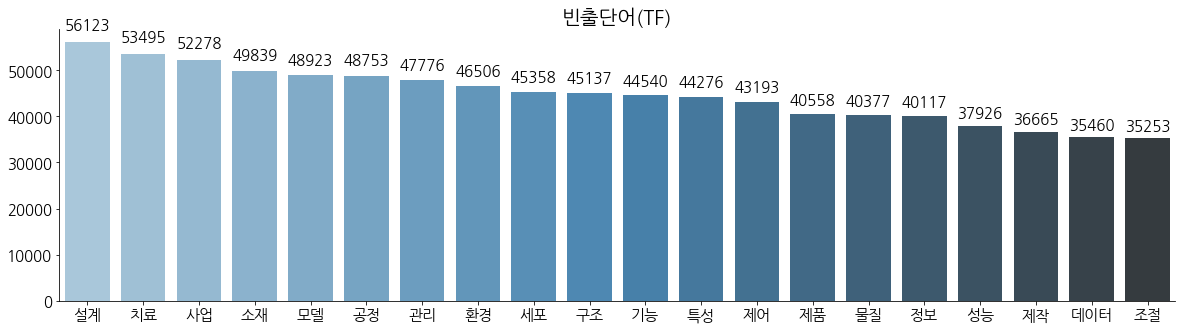

In [ ]:
# 캔버스 사이즈 적용
plt.rcParams["figure.figsize"] = (20, 5)

ax = sns.barplot(data = df_nouns[:20], x='word', y='count', palette='Blues_d')

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.0f"%(height), (left+width/2, height*1.05), ha='center', fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('')
plt.title('빈출단어(TF)', fontsize=20)
sns.despine()

plt.show()

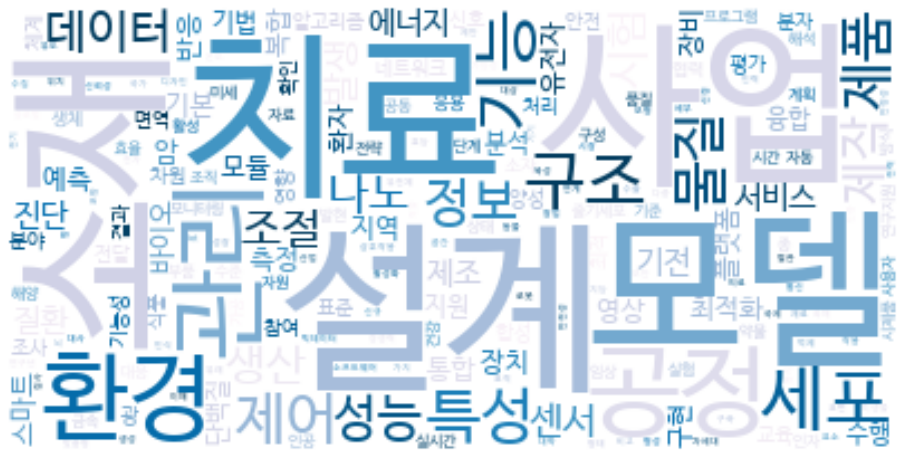

In [ ]:
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 한글 폰트 문제 해결

palettes = ['PuBu'] # 'spring', 'summer', 'seismic' colormap = palettes[0]

wordcloud = WordCloud(font_path = font_path, background_color='white', colormap = palettes[0]).generate_from_frequencies(count_dict)
fig = plt.figure(figsize=(16, 16))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')

# **TF-IDF**

In [ ]:
train['vocab_str'] = train['vocab'].apply(lambda x: ", ".join(x))

In [ ]:
train.vocab_str

0         농산물, 안전성, 유전, 정보, 해충, 분류군, 동정, 뉴클레오티드, 염기서열, 분...
1         지역, 대학, 우수, 과학자, 지원, 사업, 년년, 대장암, trail, 내성, 표...
2         혁신, 기업, 비목, 셀룰로오스, 식물, 자원, 기능성, 부직포, 고부가가치, 뷰티...
3         창업, 사업화, 연계, 소화기, 암, 진단, 분자영상, 형광, 프로브, 분자, 진단...
4         기본, 연구지원, 위암, 환자, 항암제, 반응, 예측, brca, 발현, 검사, b...
                                ...                        
174299    중견, 혈관, 내막, 증식, 치료, 표적, 분자, 발굴, 혈관, 내막, 증식, 혈관...
174300    중견, 곤란, 물성, 조절, 식품, 유동층, 과립, 복합, 소재, 유변, 물성, 변...
174301    공분야, 학문, 후속, 세대, 양성, 대통령, postdoc, 펠로우, 식물, 유전...
174302    유용, 형질, 대량, 특성, 평가, 육종, 모본, 발굴, 콩, 유전자원, 내건성, ...
174303    공분야, 학문, 후속, 세대, 양성, 박사, 연수, 광학적, 위상, 제어, 기법, ...
Name: vocab_str, Length: 174304, dtype: object

In [ ]:
#빈도수 0.05이하, 0.95이상의 빈도수 단어들 제거

tfidf = TfidfVectorizer(ngram_range=(1, 1),              # unigram
                            min_df=0.05, max_df=0.95)

tfidf_matrix = tfidf.fit_transform(train.vocab_str)

print(tfidf_matrix.shape)

In [ ]:
tfidfDf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names())

In [ ]:
pd.options.display.float_format = '{:.3f}'.format
tfidfDf.sum(axis=0).sort_values(ascending=False)[:20]

In [ ]:
df_tfidf = pd.DataFrame(tfidfDf.sum(axis=0).sort_values(ascending=False))
df_tfidf.reset_index(inplace=True)
df_tfidf.columns=['word', 'score']
df_tfidf.head()

In [ ]:
# 캔버스 사이즈 적용
plt.rcParams["figure.figsize"] = (20, 5)

ax = sns.barplot(data = df_tfidf[:20], x='word', y='score', palette='Blues_d')

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.2f"%(height), (left+width/2, height*1.05), ha='center', fontsize=12)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('')
plt.title('빈출단어(TF-IDF)', fontsize=20)
sns.despine()

plt.show()

In [ ]:
palettes = ['PuBu'] # 'spring', 'summer', 'seismic' colormap = palettes[0]

wordcloud = WordCloud(font_path = font_path, background_color='white', colormap = palettes[0]).generate_from_frequencies(tfidfDf.sum(axis=0))
fig = plt.figure(figsize=(16, 16))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')

# **W2V and Glove**

In [ ]:
tokenized_data = []

for word in tqdm(train.vocab):
    tokenized_data.append(word)

100%|██████████| 174304/174304 [00:00<00:00, 1596406.56it/s]


문장의 최대 길이 : 502
문장의 평균 길이 : 73.3869618597393


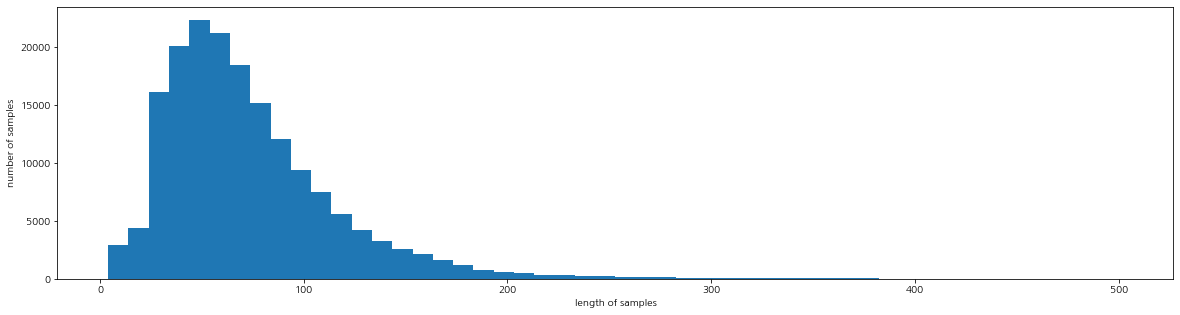

In [ ]:
print('문장의 최대 길이 :',max(len(l) for l in tokenized_data))
print('문장의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## **W2V**

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(66437, 100)

In [ ]:
print("기후 유사단어 :", model.wv.most_similar("기후"))

기후 유사단어 : [('기후변화', 0.7415908575057983), ('전지구', 0.7264883518218994), ('중위', 0.712082028388977), ('계절', 0.6951780915260315), ('예측성', 0.691137433052063), ('기온', 0.6819902062416077), ('몬순', 0.6673480868339539), ('북극', 0.6582320928573608), ('열대저기압', 0.6580561399459839), ('한반도', 0.656804621219635)]


## **Glove**

In [ ]:
!pip install glove_python_binary

In [ ]:
from glove import Corpus, Glove
corpus_g = Corpus() 

# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
corpus_g.fit(tokenized_data, window=5)
glove = Glove(no_components=100, learning_rate=0.05)

# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
glove.fit(corpus_g.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus_g.dictionary)

Performing 20 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [ ]:
print("기후 유사단어 :", glove.most_similar("기후"))

기후 유사단어 : [('공간권', 0.7236138435787596), ('융행', 0.7193625044704021), ('변동성', 0.6701375862947972), ('기후변화', 0.6564333680312827)]


## **군집**

### **PCA**

0.07478875875264832


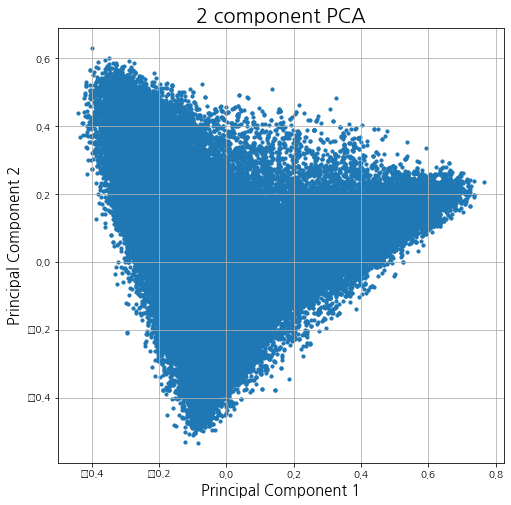

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(tfidf_matrix.toarray())

# 주성분으로 이루어진 데이터 프레임 구성
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

# 고윳값이 설명 가능한 분산량
print(sum(pca.explained_variance_ratio_))

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

ax.scatter(principalDf['principal component1'], principalDf['principal component2'], s=10)

ax.grid()

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = sorted(clutser.cluster_label.unique().tolist())
colors = ['g', 'r', 'b', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = clutser['cluster_label'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

### **T-SNE**

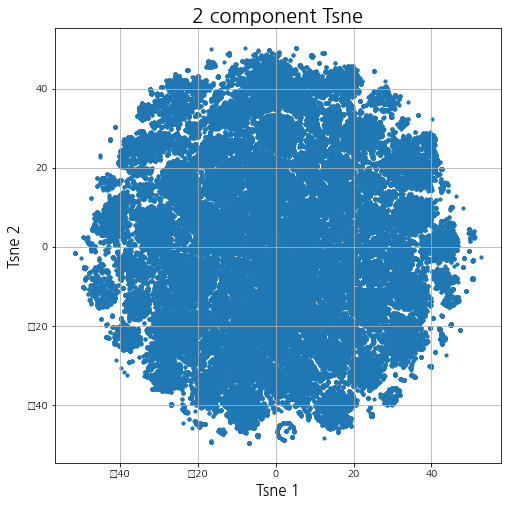

In [ ]:
# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
model = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
tsne_result = model.fit_transform(tfidf_matrix.toarray())

# 데이터 프레임 구성
tsneDf = pd.DataFrame(data=tsne_result, columns = ['tsne1', 'tsne2'])

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Tsne 1', fontsize = 15)
ax.set_ylabel('Tsne 2', fontsize = 15)
ax.set_title('2 component Tsne', fontsize=20)

ax.scatter(tsneDf['tsne1'], tsneDf['tsne2'], s=10)

ax.grid()

### **K-means Clustering**

In [ ]:
# K-means로 24개 군집으로 문서 군집화시키기
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=24, max_iter=10000, random_state=42)

# 예측
cluster_label = kmeans.fit_predict(tfidf_matrix)

In [ ]:
cluster = pd.DataFrame()

# 군집화한 레이블값들을 df에 추가하기
cluster['cluster_label'] = cluster_label
cluster['contents'] = train['vocab_str']
# cluster.sort_values(by=['cluster_label'])

In [ ]:
cluster['orginal'] = train['label']

In [ ]:
clutser['compare'] = clutser['orginal'] == clutser['cluster_label']

In [ ]:
print("원 라벨과 일치 비율 : {:.2f} %".format(clutser['compare'].sum() / cluster.shape[0] * 100))

원 라벨과 일치 비율 : 2.83 %


### **Clustering Result - PCA**

In [ ]:
# K-means로 2개 군집으로 문서 군집화시키기
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=10000, random_state=42)

# 예측
cluster_label = kmeans.fit_predict(tfidf_matrix)

In [ ]:
cluster = pd.DataFrame()

# 군집화한 레이블값들을 df에 추가하기
cluster['cluster_label'] = cluster_label
cluster['contents'] = train['vocab_str']
cluster.sort_values(by=['cluster_label'])

,cluster_label,contents
94850,0,"고급, 과학자, 초빙, brain, pool, 젖소, 대사성, 질병, 장내, 미생물..."
154876,0,"항노화, 화장품, 지원, 아디포넥틴, 면역, 피부, 장벽, 기능, 피부, 노화, 억..."
23116,0,"후속, 연구지원, rna, regulon-user, 분석, 전이, 억제, 유전자, ..."
44231,0,"중견, 연구비억, 초과, 억이하, 저항성, 암, 소세포, 폐암, 전사인자, ascl..."
154879,0,"중견, 연구비억, 초과, 억이하, 스플라이싱, 돌연변이, 선천성, 난청, 청각, 기..."
...,...,...
63152,1,"자유, 공모, 드론, hd, 영상, 정보, 실시간, 전송, 통신, 프로토콜, soc..."
63153,1,"원자력, 국제, 협력, 조성, 나노, 구조, 하이브리드, 복합체, 고도, 방사성, ..."
63154,1,"기본, 연구지원, 사업, 고정밀, 위치, 측위, 드론, 편대, 비행, vr, 융합,..."
63147,1,"제품, 공정, 자동차, 쇽업쇼버, 스트러트마운팅, 볼트, 베어링, 압입, 공정자동화..."


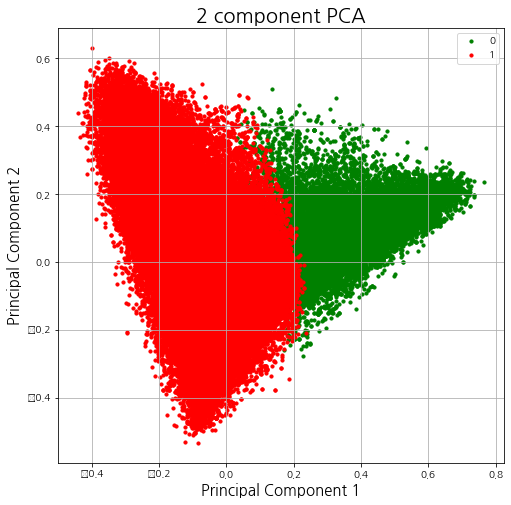

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = sorted(clutser.cluster_label.unique().tolist())
colors = ['g', 'r']

for target, color in zip(targets,colors):
    indicesToKeep = clutser['cluster_label'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

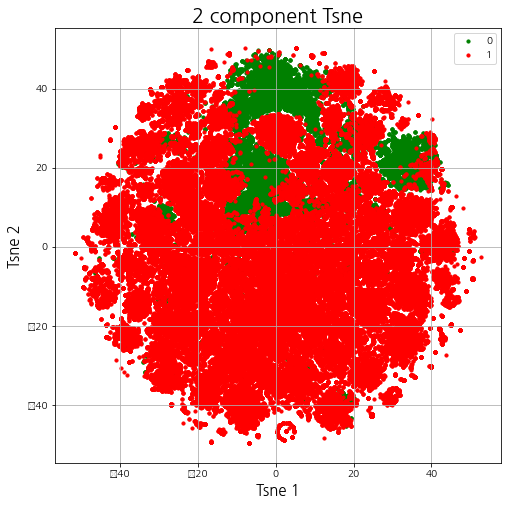

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Tsne 1', fontsize = 15)
ax.set_ylabel('Tsne 2', fontsize = 15)
ax.set_title('2 component Tsne', fontsize=20)

targets = sorted(clutser.cluster_label.unique().tolist())
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = clutser['cluster_label'] == target
    ax.scatter(tsneDf.loc[indicesToKeep, 'tsne1']
               , tsneDf.loc[indicesToKeep, 'tsne2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

---

# **예측 분류**

In [ ]:
tokenizer=Tokenizer(oov_token = 'OOV')

tokenizer.fit_on_texts(list(train['vocab']))
word_vocab = tokenizer.word_index

vocab_size = len(word_vocab)+2

In [ ]:
threshold = 10
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

print('예상 단어집합 크기 :',total_cnt - rare_cnt)
words_num = total_cnt - rare_cnt

단어 집합(vocabulary)의 크기 : 165958
등장 빈도가 9번 이하인 희귀 단어의 수: 121699
단어 집합에서 희귀 단어의 비율: 73.33120428060111
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.6347518664728007
예상 단어집합 크기 : 44259


In [ ]:
# tokenizer=Tokenizer()
tokenizer=Tokenizer(num_words=words_num,oov_token = 'OOV')

tokenizer.fit_on_texts(list(train['vocab']))
word_vocab = tokenizer.word_index

vocab_size = len(word_vocab)+2

In [ ]:
train['input_0'] = train['fixed_okt_내역사업명'] + train['fixed_okt_과제명'] + train['fixed_okt_요약문_한글키워드']
train['input_1'] = train['filter_okt_요약문_연구목표']

In [ ]:
test['input_0'] = test['fixed_okt_내역사업명'] + test['fixed_okt_과제명'] + test['fixed_okt_요약문_한글키워드']
test['input_1'] = test['filter_okt_요약문_연구목표']

In [ ]:
train_length = train['input_0'].apply(len)
train_length.head()

# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('인풋 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('인풋 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

number = 98
print('인풋 길이 {}%: {}'.format(number,np.percentile(train_length, number)))

인풋 길이 제 1 사분위: 17.0
인풋 길이 제 3 사분위: 25.0
인풋 길이 98%: 35.0


In [ ]:
train_length = train['input_1'].apply(len)
train_length.head()

# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('인풋 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('인풋 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

number = 98
print('인풋 길이 {}%: {}'.format(number,np.percentile(train_length, number)))

인풋 길이 제 1 사분위: 23.0
인풋 길이 제 3 사분위: 68.0
인풋 길이 98%: 170.0


In [ ]:
# 0이 아닌 데이터 2번 복사하여 추가, 추가로 오답률이 높은 label 2번 복사하여 추가 
temp = train.copy()
temp1 = temp[temp['label'] != 0]
temp2 = temp[(temp['label'] == 11)|(temp['label'] == 12)|(temp['label'] == 13)|(temp['label'] == 17)|(temp['label'] == 20)|(temp['label'] == 23)|(temp['label'] == 25)|(temp['label'] == 26)|(temp['label'] == 37)|(temp['label'] == 38)]

temp = pd.concat([temp, temp1], axis = 0).reset_index(drop = True)
temp = pd.concat([temp, temp1], axis = 0).reset_index(drop = True)
temp = pd.concat([temp, temp2], axis = 0).reset_index(drop = True)
temp = pd.concat([temp, temp2], axis = 0).reset_index(drop = True)

In [ ]:
max_len = [35, 170]


# train_encoded_0 = tokenizer.texts_to_sequences(list(train['input_0']))
train_encoded_0 = tokenizer.texts_to_sequences(list(temp['input_0']))
train_input_0 = pad_sequences(train_encoded_0, maxlen=max_len[0], padding='post')

# train_encoded_1 = tokenizer.texts_to_sequences(list(train['input_1']))
train_encoded_1 = tokenizer.texts_to_sequences(list(temp['input_1']))
train_input_1 = pad_sequences(train_encoded_1, maxlen=max_len[1], padding='post')

train_input_0 = tf.convert_to_tensor(train_input_0, dtype=tf.float32)
train_input_1 = tf.convert_to_tensor(train_input_1, dtype=tf.float32)

train_input = []
train_input.append(train_input_0)
train_input.append(train_input_1)

In [ ]:
test_encoded_0 = tokenizer.texts_to_sequences(list(test['input_0']))
test_input_0 = pad_sequences(test_encoded_0, maxlen=max_len[0], padding='post')

test_encoded_1 = tokenizer.texts_to_sequences(list(test['input_1']))
test_input_1 = pad_sequences(test_encoded_1, maxlen=max_len[1], padding='post')

test_input_0 = tf.convert_to_tensor(test_input_0, dtype=tf.float32)
test_input_1 = tf.convert_to_tensor(test_input_1, dtype=tf.float32)

test_input = []
test_input.append(test_input_0)
test_input.append(test_input_1)

In [ ]:
def trans_label(number):
    vector =  np.array([0] * 46)
    vector[number] = 1
    return vector

# train['label_vector'] = train['label'].apply(trans_label)
# labels = tf.convert_to_tensor(list(train['label_vector']), dtype=tf.float32)

temp['label_vector'] = temp['label'].apply(trans_label)
labels = tf.convert_to_tensor(list(temp['label_vector']), dtype=tf.float32)

In [ ]:
embedding_dim = [512, 512]

def convolutional_model(embedding_dim = embedding_dim, max_len = max_len, num_labels = 46):
    
    train_input_0 = tf.keras.Input(shape=(max_len[0],))
    train_input_1 = tf.keras.Input(shape=(max_len[1],))


    x0 = tf.keras.layers.Embedding(vocab_size, embedding_dim[0], input_length=max_len[0], mask_zero=True)(train_input_0)
    x0 = tf.keras.layers.Dropout(0.2)(x0)

    x0 = tf.keras.layers.Conv1D(embedding_dim[0], kernel_size=3, padding='valid', activation=None)(x0)
    x0 = tf.keras.layers.BatchNormalization()(x0)
    x0 = tf.keras.layers.Activation('relu')(x0)
    x0 = tf.keras.layers.Dropout(0.2)(x0)
    x0 = tf.keras.layers.GlobalMaxPooling1D()(x0)

    x0 = tf.keras.layers.Dense(128, activation=None)(x0)
    x0 = tf.keras.layers.BatchNormalization()(x0)
    x0 = tf.keras.layers.Activation('relu')(x0)
    x0 = tf.keras.layers.Dropout(0.2)(x0)

    # x0 = Dense(num_labels, activation = 'softmax')(x0)


    x1 = tf.keras.layers.Embedding(vocab_size, embedding_dim[1], input_length=max_len[1], mask_zero=True)(train_input_1)
    x1 = tf.keras.layers.Dropout(0.2)(x1)
    
    x1 = tf.keras.layers.Conv1D(embedding_dim[1], kernel_size=3, padding='valid', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Dropout(0.2)(x1)
    x1 = tf.keras.layers.GlobalMaxPooling1D()(x1)

    x1 = tf.keras.layers.Dense(128, activation=None)(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Dropout(0.2)(x1)

    # x1 = Dense(num_labels, activation = 'softmax')(x1)

    fc = tf.keras.layers.Concatenate()([x0,x1])

    fc = tf.keras.layers.Dense(128, activation=None)(fc)
    fc = tf.keras.layers.BatchNormalization()(fc)
    fc = tf.keras.layers.Activation('relu')(fc)
    fc = tf.keras.layers.Dropout(0.2)(fc)

    labels = tf.keras.layers.Dense(num_labels, activation = 'softmax')(fc)
    
    model = tf.keras.Model([train_input_0,train_input_1], labels)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer = optimizer, loss = 'CategoricalCrossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
from PIL import Image

model = convolutional_model()
tf.keras.utils.plot_model(model, dpi = 500, show_shapes=True)
img = Image.open('model.png')
img

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 15)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

model = convolutional_model()


num_epochs = 60

history = model.fit(train_input, labels, epochs=num_epochs, batch_size=4096, verbose=1, validation_split=0.2, callbacks=[es, mc])

Epoch 1/60
49/49 [==============================] - ETA: 0s - loss: 1.5098 - accuracy: 0.6989 
Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to best_model.h5
49/49 [==============================] - 2451s 50s/step - loss: 1.5098 - accuracy: 0.6989 - val_loss: 4.1089 - val_accuracy: 0.0000e+00
Epoch 2/60
49/49 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.8963 
Epoch 00002: val_accuracy did not improve from 0.00000
49/49 [==============================] - 2424s 50s/step - loss: 0.4485 - accuracy: 0.8963 - val_loss: 5.6009 - val_accuracy: 0.0000e+00
Epoch 3/60
49/49 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9459 
Epoch 00003: val_accuracy did not improve from 0.00000
49/49 [==============================] - 2427s 50s/step - loss: 0.2265 - accuracy: 0.9459 - val_loss: 6.6795 - val_accuracy: 0.0000e+00
Epoch 4/60
49/49 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.9680 
Epoch 00004: va

KeyboardInterrupt: ignored

In [ ]:
num_epochs = 5

history = model.fit(train_input, labels, epochs=num_epochs, batch_size=4096, verbose=1, validation_split=0.2, callbacks=[es, mc])

Epoch 1/5
12/49 [======>.......................] - ETA: 29:50 - loss: 0.0129 - accuracy: 0.9958

KeyboardInterrupt: ignored

In [ ]:
num_epochs = 5

history = model.fit(train_input, labels, epochs=num_epochs, batch_size=4096, verbose=1, validation_split=0.2, callbacks=[es, mc])

In [ ]:
num_epochs = 5

history = model.fit(train_input, labels, epochs=num_epochs, batch_size=4096, verbose=1, validation_split=0.2, callbacks=[es, mc])

In [ ]:
num_epochs = 5

history = model.fit(train_input, labels, epochs=num_epochs, batch_size=4096, verbose=1, validation_split=0.2, callbacks=[es, mc])

In [ ]:
model.load_weights('best_model.h5')

In [ ]:
# 제출 파일 작성
pred=model.predict(test_input)
pred=tf.argmax(pred, axis=1)
sample_submission['label']=pred
sample_submission.to_csv('convolutional_submission.csv', index=False)